# NLP FROM SCRATCH: GENERATING NAMES WITH A CHARACTER-LEVEL RNN

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [2]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): 
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
    
n_categories = len(all_categories)
print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))
print(n_categories)

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal
18


In [12]:
category_lines['Arabic']

['Khoury',
 'Nahas',
 'Daher',
 'Gerges',
 'Nazari',
 'Maalouf',
 'Gerges',
 'Naifeh',
 'Guirguis',
 'Baba',
 'Sabbagh',
 'Attia',
 'Tahan',
 'Haddad',
 'Aswad',
 'Najjar',
 'Dagher',
 'Maloof',
 'Isa',
 'Asghar',
 'Nader',
 'Gaber',
 'Abboud',
 'Maalouf',
 'Zogby',
 'Srour',
 'Bahar',
 'Mustafa',
 'Hanania',
 'Daher',
 'Tuma',
 'Nahas',
 'Saliba',
 'Shamoon',
 'Handal',
 'Baba',
 'Amari',
 'Bahar',
 'Atiyeh',
 'Said',
 'Khouri',
 'Tahan',
 'Baba',
 'Mustafa',
 'Guirguis',
 'Sleiman',
 'Seif',
 'Dagher',
 'Bahar',
 'Gaber',
 'Harb',
 'Seif',
 'Asker',
 'Nader',
 'Antar',
 'Awad',
 'Srour',
 'Shadid',
 'Hajjar',
 'Hanania',
 'Kalb',
 'Shadid',
 'Bazzi',
 'Mustafa',
 'Masih',
 'Ghanem',
 'Haddad',
 'Isa',
 'Antoun',
 'Sarraf',
 'Sleiman',
 'Dagher',
 'Najjar',
 'Malouf',
 'Nahas',
 'Naser',
 'Saliba',
 'Shamon',
 'Malouf',
 'Kalb',
 'Daher',
 'Maalouf',
 'Wasem',
 'Kanaan',
 'Naifeh',
 'Boutros',
 'Moghadam',
 'Masih',
 'Sleiman',
 'Aswad',
 'Cham',
 'Assaf',
 'Quraishi',
 'Shalhoub',
 '

In [15]:
def read_all_files(path):
    all_categories, category_lines = [], {}
    for filename in findFiles(path):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        lines = readLines(filename)
        category_lines[category] = lines
    return all_categories, category_lines

path = 'data/names/*.txt'
names_kind, names_content = read_all_files(path)

In [17]:
names_kind,names_content

(['Arabic',
  'Chinese',
  'Czech',
  'Dutch',
  'English',
  'French',
  'German',
  'Greek',
  'Irish',
  'Italian',
  'Japanese',
  'Korean',
  'Polish',
  'Portuguese',
  'Russian',
  'Scottish',
  'Spanish',
  'Vietnamese'],
 {'Arabic': ['Khoury',
   'Nahas',
   'Daher',
   'Gerges',
   'Nazari',
   'Maalouf',
   'Gerges',
   'Naifeh',
   'Guirguis',
   'Baba',
   'Sabbagh',
   'Attia',
   'Tahan',
   'Haddad',
   'Aswad',
   'Najjar',
   'Dagher',
   'Maloof',
   'Isa',
   'Asghar',
   'Nader',
   'Gaber',
   'Abboud',
   'Maalouf',
   'Zogby',
   'Srour',
   'Bahar',
   'Mustafa',
   'Hanania',
   'Daher',
   'Tuma',
   'Nahas',
   'Saliba',
   'Shamoon',
   'Handal',
   'Baba',
   'Amari',
   'Bahar',
   'Atiyeh',
   'Said',
   'Khouri',
   'Tahan',
   'Baba',
   'Mustafa',
   'Guirguis',
   'Sleiman',
   'Seif',
   'Dagher',
   'Bahar',
   'Gaber',
   'Harb',
   'Seif',
   'Asker',
   'Nader',
   'Antar',
   'Awad',
   'Srour',
   'Shadid',
   'Hajjar',
   'Hanania',
   'Kalb'

# Creating the Network

In [35]:
import torch
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [36]:
import random
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [37]:
# one-hot
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor


# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [38]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [39]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [40]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [41]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 40s (5000 5%) 2.6905
1m 20s (10000 10%) 2.1663
1m 59s (15000 15%) 2.6968
2m 39s (20000 20%) 2.7007
3m 18s (25000 25%) 2.1532
3m 58s (30000 30%) 2.5381
4m 36s (35000 35%) 3.1625
5m 15s (40000 40%) 1.6435
5m 54s (45000 45%) 3.0995
6m 30s (50000 50%) 2.1437
7m 8s (55000 55%) 2.0887
7m 45s (60000 60%) 2.6935
8m 24s (65000 65%) 2.3329
9m 3s (70000 70%) 2.3764
9m 40s (75000 75%) 2.0148
10m 18s (80000 80%) 2.5101
10m 56s (85000 85%) 1.0268
11m 36s (90000 90%) 2.5484
12m 14s (95000 95%) 2.1782
12m 50s (100000 100%) 2.1387


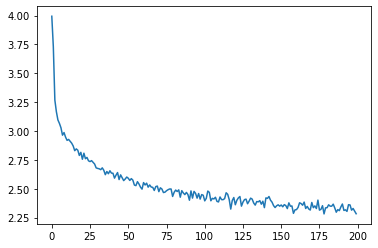

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [43]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [44]:
# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovakov
Uarakov
Santovak
Garterr
Erenger
Ranger
Salla
Parez
Allan
Chan
Han
Iun
